# Fine-tune ConvNeXT for image classification

This notebook was created as part of [this YouTube video](https://youtu.be/Hn1IgPY42Bw).

It illustrates how to fine-tune [ConvNeXT](https://huggingface.co/docs/transformers/model_doc/convnext), a state-of-the-art image classifier by Meta AI, on a custom dataset (in this case, the [EuroSAT](https://github.com/phelber/EuroSAT) dataset).

## Set-up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 28.1 MB/s eta 0:00:00


## Load dataset

In [3]:
from datasets import load_dataset

# we can load a custom dataset using the "imagefolder" feature
# details: https://huggingface.co/docs/datasets/image_process#imagefolder
# dataset = load_dataset(r"F:\arairdin\ME592\image_folder\train")
dataset = load_dataset("/content/drive/MyDrive/train")

Resolving data files:   0%|          | 0/14008 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/train-a0c08f50a5d66e3c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14008
    })
})

In [5]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Chinee apple', 'Lantana', 'Negative', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed'], id=None)}

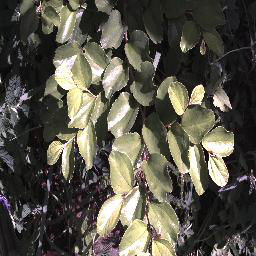

In [6]:
example = dataset["train"][0]
example["image"]

In [7]:
example["label"]

0

In [42]:
labels = dataset["train"].features["label"].names
print(labels)

['Chinee apple', 'Lantana', 'Negative', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed']


In [9]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'Chinee apple', 1: 'Lantana', 2: 'Negative', 3: 'Parkinsonia', 4: 'Parthenium', 5: 'Prickly acacia', 6: 'Rubber vine', 7: 'Siam weed', 8: 'Snake weed'}


In [10]:
id2label[0]

'Chinee apple'

## Process data

In [11]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

/usr/local/lib/python3.9/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [12]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [13]:

from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose(
    [
     RandomResizedCrop(224),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples

In [ ]:
# !pip install torchvision

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14008
    })
})

In [15]:
processed_dataset = dataset.with_transform(train_transforms)

In [16]:
processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

## Define model

In [17]:
len(labels)

9

In [18]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Move model to GPU

In [19]:
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [20]:
print(device)

cuda


In [21]:
processed_dataset["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F91D1D87490>,
 'label': 0,
 'pixel_values': tensor([[[-1.8097, -1.8097, -1.8268,  ..., -1.9295, -1.9124, -1.8610],
          [-1.8097, -1.8268, -1.8268,  ..., -1.8782, -1.8268, -1.7240],
          [-1.7925, -1.8268, -1.8439,  ..., -1.7754, -1.7069, -1.6042],
          ...,
          [-1.4672, -1.3473, -1.5699,  ..., -0.7479, -0.5767, -0.2513],
          [-1.4843, -1.3302, -1.5528,  ..., -0.8164, -0.4397, -0.4054],
          [-1.4500, -1.3130, -1.5185,  ..., -1.2788, -1.1932, -0.4397]],
 
         [[-1.6856, -1.6856, -1.7031,  ..., -1.8431, -1.8256, -1.7731],
          [-1.6856, -1.7031, -1.7031,  ..., -1.7906, -1.7381, -1.6331],
          [-1.6681, -1.7031, -1.7206,  ..., -1.6856, -1.6155, -1.5105],
          ...,
          [-1.4055, -1.2829, -1.5105,  ..., -0.6352, -0.4601, -0.1275],
          [-1.4230, -1.2654, -1.4930,  ..., -0.7227, -0.3200, -0.3025],
          [-1.3880, -1.2479, -1.4580,  ..., -1.1954, 

In [22]:
from torch.utils.data import DataLoader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle=True)

In [23]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [24]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

True
2.0.0+cu118


## Train the model

In [25]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

epoch_loss = []
epoch_accuracy = []
index_loss = []
index_accuracy = []

model.train()
for epoch in range(5):
    print("Epoch:", epoch)
    correct = 0
    total = 0
    for idx, batch in enumerate(tqdm(dataloader)):
        # move batch to GPU
        batch = {k:v.to(device) for k,v in batch.items()}

        optimizer.zero_grad()

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"],
                        labels=batch["labels"])

        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()

        # metrics
        total += batch["labels"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()

        accuracy = correct/total

        if idx % 1000 == 0:
            print(f"Loss after {idx} steps:", loss.item())
            print(f"Accuracy after {idx} steps:", accuracy)
            index_loss.append(loss.item())
            index_accuracy.append(accuracy)
    epoch_loss.append(loss.item())
    epoch_accuracy.append(accuracy)


Epoch: 0


  0%|          | 0/3502 [00:00<?, ?it/s]

Loss after 0 steps: 2.283625602722168
Accuracy after 0 steps: 0.0
Loss after 1000 steps: 0.05125359445810318
Accuracy after 1000 steps: 0.7017982017982018
Loss after 2000 steps: 0.0581633560359478
Accuracy after 2000 steps: 0.7817341329335332
Loss after 3000 steps: 0.015437731519341469
Accuracy after 3000 steps: 0.8194768410529824
Epoch: 1


  0%|          | 0/3502 [00:00<?, ?it/s]

Loss after 0 steps: 0.011500291526317596
Accuracy after 0 steps: 1.0
Loss after 1000 steps: 0.007240357808768749
Accuracy after 1000 steps: 0.9295704295704296
Loss after 2000 steps: 0.004446057602763176
Accuracy after 2000 steps: 0.9274112943528235
Loss after 3000 steps: 1.1192013025283813
Accuracy after 3000 steps: 0.9281906031322892
Epoch: 2


  0%|          | 0/3502 [00:00<?, ?it/s]

Loss after 0 steps: 0.016999343410134315
Accuracy after 0 steps: 1.0
Loss after 1000 steps: 0.36022230982780457
Accuracy after 1000 steps: 0.9468031968031968
Loss after 2000 steps: 0.4448351263999939
Accuracy after 2000 steps: 0.9481509245377311
Loss after 3000 steps: 0.5321406722068787
Accuracy after 3000 steps: 0.9469343552149283
Epoch: 3


  0%|          | 0/3502 [00:00<?, ?it/s]

Loss after 0 steps: 0.7358742952346802
Accuracy after 0 steps: 0.75
Loss after 1000 steps: 0.3243398070335388
Accuracy after 1000 steps: 0.9627872127872128
Loss after 2000 steps: 0.06775966286659241
Accuracy after 2000 steps: 0.9551474262868566
Loss after 3000 steps: 0.003968794830143452
Accuracy after 3000 steps: 0.9565144951682772
Epoch: 4


  0%|          | 0/3502 [00:00<?, ?it/s]

Loss after 0 steps: 0.12414821982383728
Accuracy after 0 steps: 1.0
Loss after 1000 steps: 0.0028811395168304443
Accuracy after 1000 steps: 0.962037962037962
Loss after 2000 steps: 0.3579730689525604
Accuracy after 2000 steps: 0.9618940529735133
Loss after 3000 steps: 0.17452579736709595
Accuracy after 3000 steps: 0.9600966344551816


## Inference

In [26]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

# feature_extractor = AutoFeatureExtractor.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")
# model = AutoModelForImageClassification.from_pretrained("nielsr/convnext-tiny-finetuned-eurosat")

In [28]:
from PIL import Image
import requests

# url = "/content/images/Lantana/20170126-095106-0.jpg"
# image = Image.open("/content/images/Chinese apple/20160928-141421-0.jpg")
# image

In [ ]:
pixel_values = feature_extractor(image.convert("RGB"), return_tensors="pt").pixel_values
pixel_values=pixel_values.to(device)
print(pixel_values.size)
print(pixel_values.type)

<built-in method size of Tensor object at 0x7f57fc5940e0>
<built-in method type of Tensor object at 0x7f57fc5940e0>


In [ ]:
print(device)

cuda


In [ ]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [ ]:
print(logits.shape)

torch.Size([1, 3])


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Chinese apple


## Pipeline API

In [29]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [ ]:
pipe(image)

[{'label': 'Forest', 'score': 0.9989117383956909},
 {'label': 'HerbaceousVegetation', 'score': 0.0005626519559882581},
 {'label': 'Pasture', 'score': 0.00034275249345228076},
 {'label': 'AnnualCrop', 'score': 5.9258782130200416e-05},
 {'label': 'SeaLake', 'score': 4.3437339627416804e-05}]

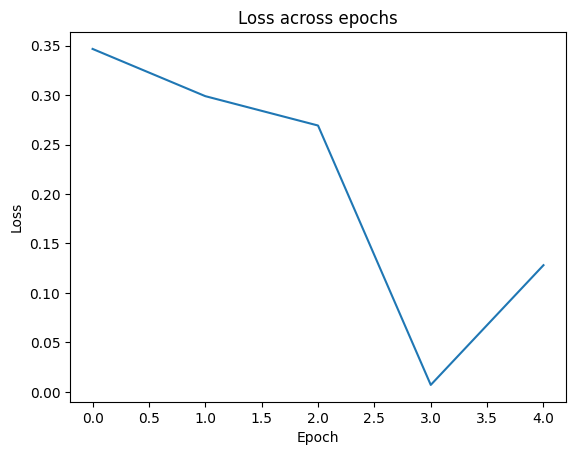

In [119]:
import matplotlib.pyplot as plt

x_values = range(0,5)
y_values = epoch_loss

plt.plot(x_values, y_values)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss across epochs')

plt.show()

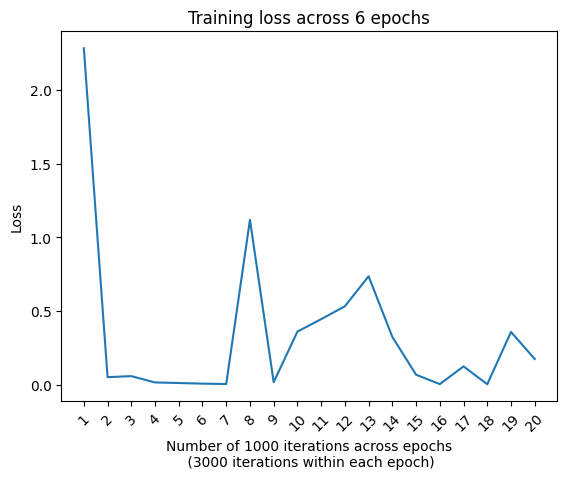

In [135]:
import matplotlib.pyplot as plt

x_values = range(0,len(index_loss))
y_values = index_loss

plt.plot(x_values, y_values)

new_ticks = range(1,21,1)
plt.xticks(x_values, new_ticks)
plt.xticks(rotation=45)

plt.xlabel('Number of 1000 iterations across epochs\n (3000 iterations within each epoch)')
plt.ylabel('Loss')
plt.title('Training loss across 6 epochs')

plt.show()

In [122]:
len(index_loss)

20

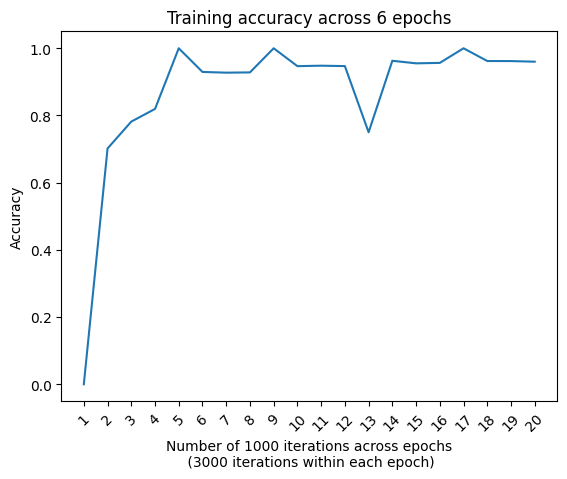

In [136]:
import matplotlib.pyplot as plt

x_values = range(0,len(index_accuracy))
y_values = index_accuracy

plt.plot(x_values, y_values)

new_ticks = range(1,21,1)
plt.xticks(x_values, new_ticks)
plt.xticks(rotation=45)

plt.xlabel('Number of 1000 iterations across epochs\n (3000 iterations within each epoch)')
plt.ylabel('Accuracy')
plt.title('Training accuracy across 6 epochs')

plt.show()

## Confusion Matrix

In [80]:
## Confusion Matrix
# Loop through images in testing folder
import os
folder_path = "/content/drive/MyDrive/test"
n = 1
actual_list = []
pred_list = []
for folder in os.listdir(folder_path):
    temp_folder_path = os.path.join(folder_path,folder)
    label = folder
    # print(label)?
    for file_name in os.listdir(temp_folder_path):
        # Load the image
        actual_list.append(label)
        img_path = os.path.join(temp_folder_path, file_name)
        img = Image.open(img_path)
        if n%100 == 0:
            print("On image:", n)
        n=+1
        #Prep image
        pixel_values = feature_extractor(img.convert("RGB"), return_tensors="pt").pixel_values
        pixel_values=pixel_values.to(device)
        # print(pixel_values.size)
        # print(pixel_values.type)
        # Make prediction for each
        with torch.no_grad():
            outputs = model(pixel_values)
            logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        # print(model.config.id2label[predicted_class_idx])
        pred_list.append(model.config.id2label[predicted_class_idx])
        # Check if prediction matches actual label
        # Need to pull correct class and compare to prediction

In [39]:
actual_list[0:10]

['Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia']

In [40]:
pred_list[0:10]

['Snake weed',
 'Parkinsonia',
 'Prickly acacia',
 'Prickly acacia',
 'Parkinsonia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia',
 'Prickly acacia']

In [81]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_list, pred_list, labels = labels)
print(cm)

[[186  25  12   0   0   0   0   0   2]
 [  2 198   4   0   0   0   0   4   6]
 [  4  25 146   0   9   0   0   0   5]
 [  0   0  12 193   1   0   0   0   0]
 [ 11   0  29   4 123  30   0   0   7]
 [  0   0   3  11   1 196   0   0   1]
 [123   2  22  16  11   2  22   0   4]
 [  0   1  16   0   0   0   0 197   0]
 [  6  17   6   0   1   0   0   0 173]]


In [63]:
print(labels)

['Chinee apple', 'Lantana', 'Negative', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed']


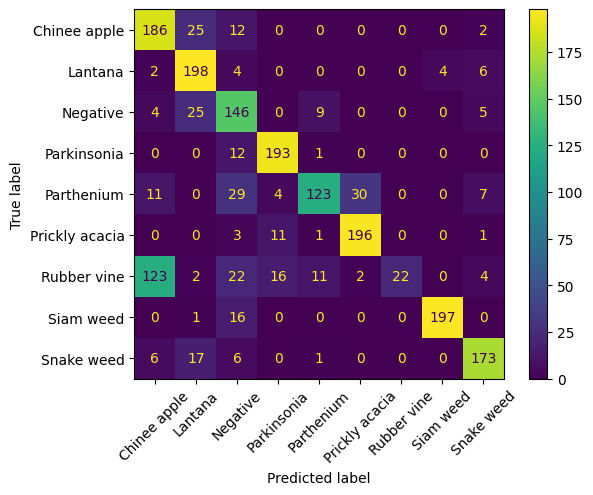

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
disp = ConfusionMatrixDisplay(cm, display_labels = labels)
disp.from_predictions(actual_list, pred_list, xticks_rotation=45)
# disp.plot()

['Prickly acacia', 'Parthenium', 'Chinee apple', 'Siam weed', 'Lantana', 'Chinee apple', 'Parkinsonia', 'Chinee apple', 'Chinee apple']
['Prickly acacia', 'Parthenium', 'Chinee apple', 'Siam weed', 'Lantana', 'Rubber vine', 'Parkinsonia', 'Snake weed', 'Negative']


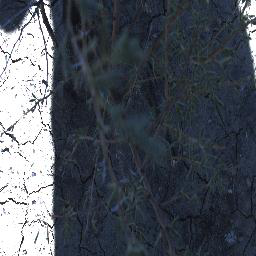

Actual Class:  Prickly acacia 
Predicted Class:  Prickly acacia


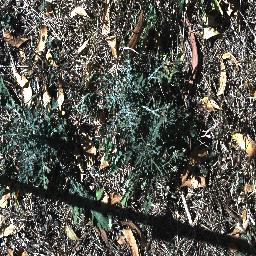

Actual Class:  Parthenium 
Predicted Class:  Parthenium


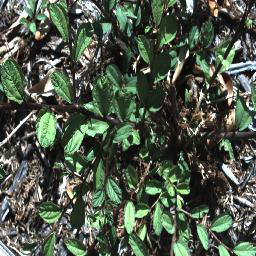

Actual Class:  Chinee apple 
Predicted Class:  Chinee apple


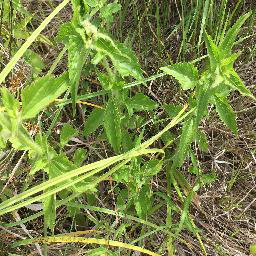

Actual Class:  Siam weed 
Predicted Class:  Siam weed


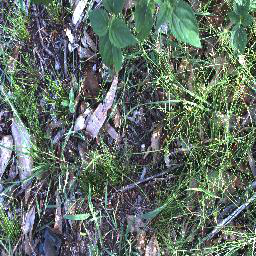

Actual Class:  Lantana 
Predicted Class:  Lantana


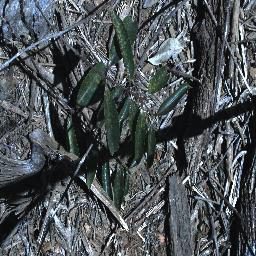

Actual Class:  Rubber vine 
Predicted Class:  Chinee apple


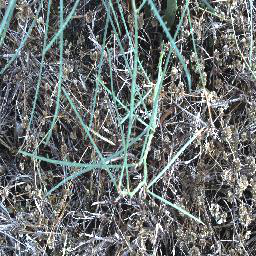

Actual Class:  Parkinsonia 
Predicted Class:  Parkinsonia


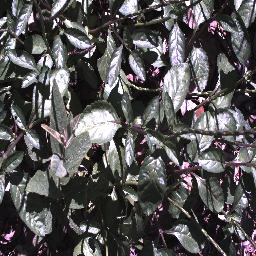

Actual Class:  Snake weed 
Predicted Class:  Chinee apple


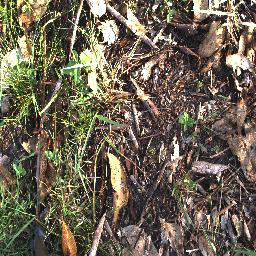

Actual Class:  Negative 
Predicted Class:  Chinee apple


In [116]:
import random
from PIL import Image

folder_path = "/content/drive/MyDrive/test"
images = []
pred_labels = []
actual_labels = []
for folder in os.listdir(folder_path):
    temp_folder_path = os.path.join(folder_path,folder)
    label = folder
    actual_labels.append(label)
    # print(temp_folder_path)
    # print(len(os.listdir(temp_folder_path)))
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(temp_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    # Select a random image file from the list
    random_image = random.choice(image_files)
    # # Open and display the image using Pillow
    image_path = os.path.join(temp_folder_path, random_image)
    img = Image.open(image_path)
    # print(image_path)
    #Prep image
    pixel_values = feature_extractor(img.convert("RGB"), return_tensors="pt").pixel_values
    pixel_values=pixel_values.to(device)
    # print(pixel_values.size)
    # print(pixel_values.type)
    # Make prediction for each
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    # print(model.config.id2label[predicted_class_idx])
    pred_labels.append(model.config.id2label[predicted_class_idx])
    images.append(image_path)
# #Look at multiple images and give the prediction accuracy#

# print(images)
print(pred_labels)
print(actual_labels)

n = 0
for i in images:
  image = Image.open(i)
  image.show()
  print("Actual Class: ", actual_labels[n], "\nPredicted Class: ", pred_labels[n])
  n = n + 1